# Analysis of audit evidence collected with the [LaLA](https://github.com/LiFaytheGoblin/moodle-tool_lala) Moodle Plugin

LaLA is a Moodle plugin to enable administrators and auditors of [Moodle Learning Analytics](https://github.com/LiFaytheGoblin/moodle-tool_lala/wiki/Moodle-Learning-Analytics) models to retrieve evidence for an audit, like the sample data collected on the Moodle instance, the calculated features and predictions made by the model. [Learn more about LaLA](https://github.com/LiFaytheGoblin/moodle-tool_lala/wiki).

An [audit of an AI-integrating system](https://github.com/LiFaytheGoblin/moodle-tool_lala/wiki/Auditing) like a Moodle Learning Analytics checks different aspects of the system's utility, validity and compliance to ethical values<sup name="text1">[1](#footnote1)</sup>. An audit consists of three steps<sup name="text1">[1](#footnote1)</sup>: 
1. Formulating claims the system is expected to fullfill
2. Gathering evidence to prove or disprove the claims
3. Validating the claims using the evidence

<sup name="footnote1">1. Fernsel, L. and Simbeck, K. (2023). Assessing the Auditability of Learning Analytics Systems: A Framework and Case Study. Forthcoming. [↩](#text1)</sup>  

## This notebook

This notebook provides an example for step 3 of an audit, claim validation. In this case, the subject of the audit is [Moodle's "Students at risk of dropping out" model](https://docs.moodle.org/402/en/Students_at_risk_of_dropping_out). First we formulate the claim that "Dropout predictions do not show bias against minority groups" (Step 1). For checking this claim we used LaLA to collect evidence from a Moodle platform: We trained a dropout prediction model and retrieved the predictions it made for a test dataset (Step 2). We can now proceed to the final step and validiate the formulated claim by checking whether the model's predictions are equally accurate for both minority and majority groups (Step 3). 

## ⚠ Warning about the validity of this analysis ##
This notebook functions only as an example for an analysis of evidence retrieved from LaLA. It should not be seen as part of a meaningful audit because of three reasons. Firstly and most importantly, because of the lack of useful training data, the data used for this analysis has been manipulated. Specifically, users have been randomly assigned to minority or majority groups, and they have been randomly assigned to the "likely to drop out" or "not likely to drop out" classes. The model predictions have been randomized as well. Therefore, the audit results do not reflect the reality. Secondly, this notebook only validates one claim, whereas in a real audit, auditors would formulate and validate numerous claims<sup name="text2">[2](#footnote2)</sup>. Thirdly, this notebook only considers the prediction accuracy difference for one type of group, whereas a real audit would consider more metrics and more groups, depending on the identified risks of inaccurate predictions.

<sup name="footnote2">2. Simbeck, K. (2023). They shall be fair, transparent, and robust: Auditing learning analytics systems. AI and Ethics. https://doi.org/10.1007/s43681-023-00292-7 [↩](#text2)</sup>  


# Analysis

## Import evidence
First, we use [pandas](https://pandas.pydata.org/docs/reference/index.html) to import evidence and load it as a pandas dataframe.

In [1]:
import pandas as pd

d_predictions = pd.read_csv("data/predictions.csv") # Import the predictions.

In [2]:
# Take a look at the imported data.
print(d_predictions.head())
print(d_predictions.describe())

    sampleid  target  prediction
0   809237-0       0           1
1   745806-0       0           0
2  1158255-0       0           0
3   506686-0       0           0
4  1977658-0       0           0
           target  prediction
count  453.000000  453.000000
mean     0.163355    0.103753
std      0.370098    0.305277
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      0.000000    0.000000
max      1.000000    1.000000


In [3]:
# Import the related user data. In this example, we chose 'lang' to be the property by which to form groups.
d_related =  pd.read_csv("data/related.csv") 

In [4]:
# Take a look at the imported data.
print(d_related.head())
print(pd.value_counts(d_related['lang']))

        id lang
0   809237   en
1   745806   de
2  1158255   de
3   506686   de
4  1977658   de
lang
en    230
de    223
Name: count, dtype: int64


/tmp/ipykernel_61379/170650683.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(d_related['lang']))


## Explore overall model quality

In this step, we use [sklearn](https://scikit-learn.org) to have a look at the overall quality of our model, as well as the quality of the model per class ("likely to drop out" or "not likely to drop out").  

In [5]:
from sklearn.metrics import classification_report

y_test = d_predictions['target']; # Get the truth values from the predictions dataframe.
y_pred = d_predictions['prediction']; # Get the prediction values from the predictions dataframe.

report = classification_report(y_test, y_pred, target_names=['Not likely to drop out', 'Likely to drop out'])

print(report)

                        precision    recall  f1-score   support

Not likely to drop out       0.83      0.89      0.86       379
    Likely to drop out       0.13      0.08      0.10        74

              accuracy                           0.76       453
             macro avg       0.48      0.49      0.48       453
          weighted avg       0.72      0.76      0.74       453


## Fairness analysis

Next, we use [fairlearn](https://fairlearn.org) to judge the quality of the results differentiated by group. Groups are defined by the attribute a user has entered as "lang" (language). While fairlearn provides many possible fairness metrics, for the simplicity of this audit, we just compare the accuracy by group. A true audit would make a risk-based selection of fairness metrics.

In [6]:
# Assign to each d_predictions the fitting lang

d_predictions['id'] = d_predictions['sampleid'].str.split('-').str[0] # Get only the id part of the sampleid

d_predictions['id'] = d_predictions['id'].astype(int)
d_related['id'] = d_related['id'].astype(int)

id_to_lang = d_related.set_index('id')['lang'].to_dict()  # Create a mapping dictionary

d_predictions['lang'] = d_predictions['id'].map(id_to_lang)

In [7]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

metrics = { "accuracy": accuracy_score } # Select fairness metrics (accuracy score)

mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=d_predictions['lang']) # Calculate the selected fairness metrics.

/home/linda/Repositories/moodle-tool_lala-example-evidence-analysis/venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/linda/Repositories/moodle-tool_lala-example-evidence-analysis/venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/linda/Repositories/moodle-tool_lala-example-evidence-analysis/venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='lang'>,
        <Axes: xlabel='lang'>]], dtype=object)

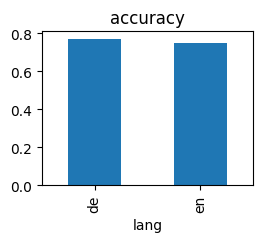

In [8]:
# Plot the calculated fairness metrics.
mf.by_group.plot.bar(
    subplots=True,
    layout=[1, 2],
    legend=False,
    figsize=[6, 2]
)

In [9]:
# Accuracy comparison: Calculate the accuracy and count difference
mf.difference()

accuracy    0.023474
dtype: float64

In [10]:
# Accuracy comparison: Calculate the accuracy and count ratio
mf.ratio()

accuracy    0.969565
dtype: float64

## Interpretation

As we can see from the plots as well as the difference and ratio calculations, the accuracies for both available groups 'en' and 'de' are about the same. Therefore we can conclude that the model does not show any bias against minority groups.